# 1. Sobre paquetes

si hace falta, correr:

```sh
!python -m spacy download es_core_news_sm
```

después todas las otras librerías no debería ser muy diferente, 

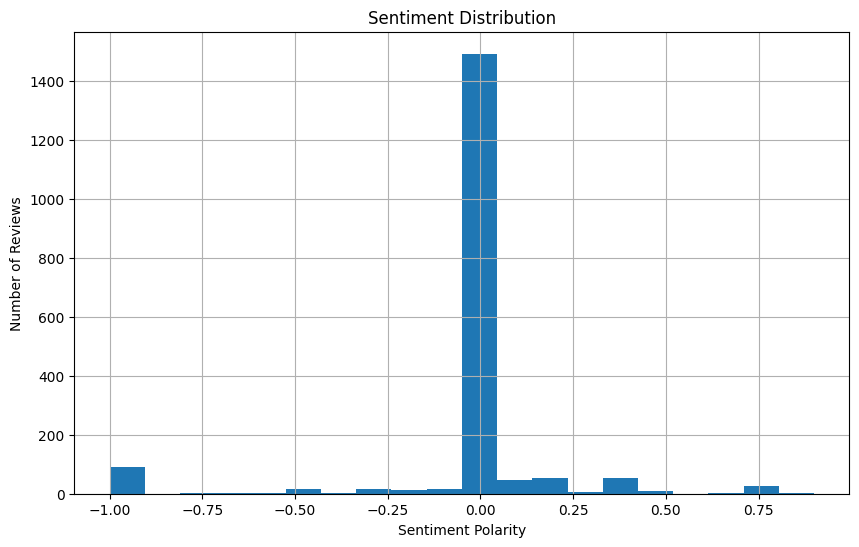

Topic 0:
vuelo pasaje cancelar empresa comprar cambiar viajar flybondi querer dinero
Topic 1:
vuelo servicio avión excelente horario viaje personal precio asiento experiencia
Topic 2:
vuelo salir hora llegar aeropuerto avión hs vuelta ida viajar
Topic 3:
vuelo viajar servicio flybondi cancelar pésimo avión empresa horario atender
Topic 4:
vuelo aerolínea hora aeropuerto flybondi cambiar cancelar servicio reprogramar dinero
Top 10 Bigrams/Trigrams:
cancelar vuelo: 293
reprogramar vuelo: 132
ida vuelta: 119
vuelo salir: 115
check in: 114
salir caro: 108
low cost: 104
cambiar vuelo: 100
cambiar horario: 95
viajar flybondi: 80


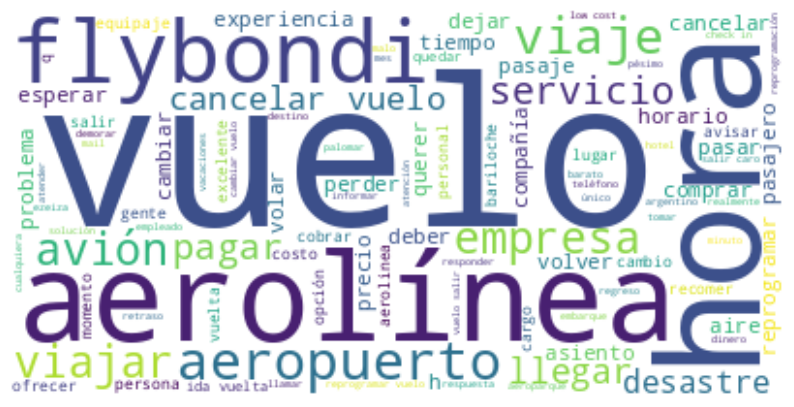

Top TF-IDF features for first review:
pago: 0.21973839608615825
miedo: 0.24952377396256156
malisimo: 0.25194007331632945
mantenimiento: 0.2600881425070311
suspender: 0.26648341246707047
vuelta: 0.27198704290348685
volvimo: 0.2739491683785511
do: 0.3010377724542282
ke: 0.3320149716722282
fly: 0.43477142665834345


,review,entities
0,malisimo malisimola peor vuando perder día hot...,[]
1,uno peor voladohar volado ciento aerolíneasest...,[]
2,terrible servicioel vuelo retrasar primero vez...,"[(terrible servicioel vuelo, MISC)]"
3,basco aerolínea bajo costocompré 6 boleto trav...,"[(basco, PER)]"
4,no reembolsar vuelo canceladosno reembolsar vu...,[]


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import spacy

# Load the dataset
df = pd.read_csv('../data/cleaned_with_lemmatized_reviews.csv')

# Selecting the 'review' column and removing missing values
reviews = df['review'].dropna()

# Load the Spanish language model for Spacy
nlp = spacy.load('es_core_news_sm')

# 1. Sentiment Analysis
def get_sentiment(review):
    blob = TextBlob(review)
    return blob.sentiment.polarity

# Applying the sentiment function
df['sentiment'] = reviews.apply(get_sentiment)

# Plotting sentiment distribution
plt.figure(figsize=(10, 6))
df['sentiment'].hist(bins=20)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Reviews')
plt.show()

# 2. Topic Modeling with LDA
stop_words = list(spacy.lang.es.stop_words.STOP_WORDS)
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)
dtm = vectorizer.fit_transform(reviews)

# Fitting the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

# 3. Word Frequency and N-grams Analysis
vectorizer_ngrams = CountVectorizer(ngram_range=(2, 3), stop_words=stop_words)
X_ngrams = vectorizer_ngrams.fit_transform(reviews)

# Summing up the occurrences of n-grams
sum_ngrams = X_ngrams.sum(axis=0)
ngrams_freq = [(word, sum_ngrams[0, idx]) for word, idx in vectorizer_ngrams.vocabulary_.items()]
ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)

# Display top 10 bigrams/trigrams
print("Top 10 Bigrams/Trigrams:")
for phrase, freq in ngrams_freq[:10]:
    print(f"{phrase}: {freq}")

# 4. Word Cloud Visualization
wordcloud = WordCloud(background_color='white', stopwords=set(spacy.lang.es.stop_words.STOP_WORDS)).generate(' '.join(reviews))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 5. TF-IDF Analysis
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(reviews)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Display top words with highest TF-IDF scores
def top_tfidf_features(row, features, top_n=10):
    topn_ids = row.argsort()[-top_n:]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    return top_feats

top_feats_in_doc = top_tfidf_features(tfidf[0].toarray()[0], tfidf_feature_names, 10)
print("Top TF-IDF features for first review:")
for feature, score in top_feats_in_doc:
    print(f"{feature}: {score}")

# 6. Aspect-Based Sentiment Analysis (ABSA)
aspects = ['vuelo', 'atención', 'precio', 'servicio', 'comodidad']

def aspect_sentiment_analysis(review, aspects):
    sentiments = {}
    doc = nlp(review)
    for token in doc:
        for aspect in aspects:
            if aspect in token.text:
                sentiments[aspect] = get_sentiment(review)
    return sentiments

df['aspect_sentiment'] = reviews.apply(lambda x: aspect_sentiment_analysis(x, aspects))

# Display aspect-based sentiment analysis results
df[['review', 'aspect_sentiment']].head()

# 7. Named Entity Recognition (NER)
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

df['entities'] = reviews.apply(extract_entities)

# Display NER results
df[['review', 'entities']].head()


In [24]:
# DF to CSV
df.to_csv('../data/processed_reviews.csv', index=False)
